In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split

from torchsummary import summary
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

import time

import random

import copy

import sklearn.metrics as skm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def data_generator(path, target_size=(256, 256), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [ ]:
# No stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmesiz"

print("Images are loading...")
NS_images = data_generator(folder_path)

print(f"Total images: {NS_images.shape[0]}")
print(f"Shapes: {NS_images[0].shape}")

Images are loading...
Total images: 4427
Shapes: torch.Size([3, 256, 256])


In [ ]:
# Stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmeli"

print("Images are loading...")
S_images = data_generator(folder_path, augmentation=True, augmentation_factor=1)

print(f"Total stroke images: {S_images.shape[0]}")
print(f"Stroke images shape: {S_images[0].shape}")

Images are loading...
Total stroke images: 4446
Stroke images shape: torch.Size([3, 256, 256])


In [ ]:
# Test images

folder_path_NS = "/content/drive/My Drive/veriler/test/inmesiz"
folder_path_S = "/content/drive/My Drive/veriler/test/inmeli"

print("Images are loading...")
NS_test_images = data_generator(folder_path_NS)
S_test_images = data_generator(folder_path_S)

print(f"Total no stroke test images: {NS_test_images.shape[0]}")
print(f"No stroke test images shape: {NS_test_images[0].shape}")

print(f"Total stroke test images: {S_test_images.shape[0]}")
print(f"Stroke test images shape: {S_test_images[0].shape}")

Images are loading...
Total no stroke test images: 130
No stroke test images shape: torch.Size([3, 256, 256])
Total stroke test images: 167
Stroke test images shape: torch.Size([3, 256, 256])


In [ ]:
# External test images

folder_path_external_NS = "/content/drive/My Drive/veriler/test/baska_test/inmesiz"
folder_path_external_S = "/content/drive/My Drive/veriler/test/baska_test/b_stroke"

print("Images are loading...")
external_NS_images = data_generator(folder_path_external_NS)
external_NS_images = external_NS_images[:192]
external_S_images = data_generator(folder_path_external_S)

print(f"Total external test no stroke images: {external_NS_images.shape[0]}")
print(f"External test no stroke images shape: {external_NS_images[0].shape}")

print(f"Total external test stroke images: {external_S_images.shape[0]}")
print(f"External test stroke images shape: {external_S_images[0].shape}")

Images are loading...
Total external test no stroke images: 192
External test no stroke images shape: torch.Size([3, 256, 256])
Total external test stroke images: 192
External test stroke images shape: torch.Size([3, 256, 256])


In [ ]:
# Combine the images

train_val_data = torch.cat((NS_images, S_images), dim=0)
train_val_labels = torch.cat((torch.zeros(NS_images.shape[0]), torch.ones(S_images.shape[0])), dim=0)
train_val_labels = train_val_labels[:,None]

test_data = torch.cat((NS_test_images, S_test_images), dim=0)
test_labels = torch.cat((torch.zeros(NS_test_images.shape[0]), torch.ones(S_test_images.shape[0])), dim=0)
test_labels = test_labels[:,None]

external_data = torch.cat((external_NS_images, external_S_images), dim=0)
external_labels = torch.cat(
    (
        torch.zeros(external_NS_images.shape[0]),
        torch.ones(external_S_images.shape[0])
    ),
    dim=0
)
external_labels = external_labels[:,None]

print(f"Train/val data shape: {train_val_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"External test data shape: {external_data.shape}")
print("--------------------------------")
print(f"Train/val labels shape: {train_val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"External test labels shape: {external_labels.shape}")
print("--------------------------------")
print(f"What is the label? (train/val) {train_val_labels[NS_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (test) {test_labels[NS_test_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (external) {external_labels[external_NS_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (train/val) {train_val_labels[NS_images.shape[0]]}") # Has to be 1
print(f"What is the label? (test) {test_labels[NS_test_images.shape[0]]}") # Has to be 1
print(f"What is the label? (external) {external_labels[external_NS_images.shape[0]]}") # Has to be 1

Train/val data shape: torch.Size([8873, 3, 256, 256])
Test data shape: torch.Size([297, 3, 256, 256])
External test data shape: torch.Size([384, 3, 256, 256])
--------------------------------
Train/val labels shape: torch.Size([8873, 1])
Test labels shape: torch.Size([297, 1])
External test labels shape: torch.Size([384, 1])
--------------------------------
What is the label? (train/val) tensor([0.])
What is the label? (test) tensor([0.])
What is the label? (external) tensor([0.])
What is the label? (train/val) tensor([1.])
What is the label? (test) tensor([1.])
What is the label? (external) tensor([1.])


In [ ]:
# Split the data into train and dev

train_data, dev_data, train_labels, dev_labels = train_test_split(
    train_val_data,
    train_val_labels,
    test_size=0.2
)

print(f"Train data shape: {train_data.shape}")
print(f"Dev data shape: {dev_data.shape}")
print("--------------------------------")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev labels shape: {dev_labels.shape}")

Train data shape: torch.Size([7098, 3, 256, 256])
Dev data shape: torch.Size([1775, 3, 256, 256])
--------------------------------
Train labels shape: torch.Size([7098, 1])
Dev labels shape: torch.Size([1775, 1])


In [ ]:
# Create the datasets

train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)
test_dataset = TensorDataset(test_data, test_labels)
external_dataset = TensorDataset(external_data, external_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
external_loader = DataLoader(external_dataset, batch_size=external_dataset.tensors[0].shape[0])

print(f"Train loader: {train_loader.dataset[0][0].shape}")
print(f"Dev loader: {dev_loader.dataset[0][0].shape}")
print(f"Test loader: {test_loader.dataset[0][0].shape}")
print(f"External test loader: {external_loader.dataset[0][0].shape}")

Train loader: torch.Size([3, 256, 256])
Dev loader: torch.Size([3, 256, 256])
Test loader: torch.Size([3, 256, 256])
External test loader: torch.Size([3, 256, 256])


In [ ]:

def medrix_model(printtoggle=False):

    # Channel Attention Modülü
    class ChannelAttention(nn.Module):
        def __init__(self, channels, reduction=16):
            super(ChannelAttention, self).__init__()
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
            self.max_pool = nn.AdaptiveMaxPool2d(1)

            self.fc = nn.Sequential(
                nn.Conv2d(channels, channels // reduction, 1),
                nn.ReLU(),
                nn.Conv2d(channels // reduction, channels, 1)
            )
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            avg_out = self.fc(self.avg_pool(x))
            max_out = self.fc(self.max_pool(x))
            out = avg_out + max_out
            return self.sigmoid(out)

    # Spatial Attention Modülü
    class SpatialAttention(nn.Module):
        def __init__(self, kernel_size=7):
            super(SpatialAttention, self).__init__()
            self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            # Kanal boyunca maksimum ve ortalama değerleri hesapla
            max_pool = torch.max(x, dim=1, keepdim=True)[0]
            avg_pool = torch.mean(x, dim=1, keepdim=True)

            # İki özellik haritasını birleştir
            concat = torch.cat([max_pool, avg_pool], dim=1)

            # Konvolüsyon ve sigmoid ile attention map oluştur
            attention_map = self.sigmoid(self.conv(concat))

            return attention_map

    # CBAM (Convolutional Block Attention Module)
    class CBAM(nn.Module):
        def __init__(self, channels, reduction=16, kernel_size=7):
            super(CBAM, self).__init__()
            self.channel_attention = ChannelAttention(channels, reduction)
            self.spatial_attention = SpatialAttention(kernel_size)

        def forward(self, x):
            # Channel attention uygula
            channel_att = self.channel_attention(x)
            x = x * channel_att

            # Spatial attention uygula
            spatial_att = self.spatial_attention(x)
            x = x * spatial_att

            return x, spatial_att

    # Ana Model Sınıfı
    class theNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            self.print = printtoggle

            ###--------------- Feature Map Layers ---------------###

            # First Convolutional Layer
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            # output size: (np.floor((256 - 3 + 2*1) / 1) + 1)/2 = 128

            # Second Convolutional Layer
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(32)
            # output size: (np.floor((128 - 3 + 2*1) / 1) + 1)/2 = 64

            # Third Convolutional Layer
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.bnorm3 = nn.BatchNorm2d(64)
            # output size: (np.floor((64 - 3 + 2*1) / 1) + 1)/2 = 32
            # Attention modülü ekle
            self.cbam3 = CBAM(64)

            # Fourth Convolutional Layer
            self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
            self.bnorm4 = nn.BatchNorm2d(128)
            # output size: (np.floor((32 - 3 + 2*1) / 1) + 1)/2 = 16

            # Fifth Convolutional Layer
            self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
            self.bnorm5 = nn.BatchNorm2d(256)
            # output size: (np.floor((16 - 3 + 2*1) / 1) + 1)/2 = 8
            # Attention modülü ekle
            self.cbam5 = CBAM(256)

            # Sixth Convolutional Layer
            self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
            self.bnorm6 = nn.BatchNorm2d(512)
            # output size: (np.floor((8 - 3 + 2*1) / 1) + 1)/2 = 4

            # Seventh Convolutional Layer
            self.conv7 = nn.Conv2d(512, 1024, 3, padding=1)
            self.bnorm7 = nn.BatchNorm2d(1024)
            # output size: (np.floor((4 - 3 + 2*1) / 1) + 1)/2 = 2
            # Attention modülü ekle
            self.cbam7 = CBAM(1024)

            ###-------------- Linear Desicion Layers --------------###

            self.fc1 = nn.Linear(1024*2*2, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 32)
            self.fc4 = nn.Linear(32, 1)

            # Attention map'leri saklamak için
            self.attention_maps = {}


        def forward(self, x):

            if self.print: print(f"Input shape: {x.shape}")

            # First Convolutional Layer
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            if self.print: print(f"After conv1: {x.shape}")

            # Second Convolutional Layer
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            if self.print: print(f"After conv2: {x.shape}")

            # Third Convolutional Layer
            x = F.max_pool2d(self.conv3(x),2)
            x = F.relu(self.bnorm3(x))
            # Attention uygula
            x, att_map3 = self.cbam3(x)
            # Attention map'i sakla
            self.attention_maps['cbam3'] = att_map3
            if self.print: print(f"After conv3 + attention: {x.shape}")

            # Fourth Convolutional Layer
            x = F.max_pool2d(self.conv4(x),2)
            x = F.relu(self.bnorm4(x))
            if self.print: print(f"After conv4: {x.shape}")

            # Fifth Convolutional Layer
            x = F.max_pool2d(self.conv5(x),2)
            x = F.relu(self.bnorm5(x))
            # Attention uygula
            x, att_map5 = self.cbam5(x)
            # Attention map'i sakla
            self.attention_maps['cbam5'] = att_map5
            if self.print: print(f"After conv5 + attention: {x.shape}")

            # Sixth Convolutional Layer
            x = F.max_pool2d(self.conv6(x),2)
            x = F.relu(self.bnorm6(x))
            if self.print: print(f"After conv6: {x.shape}")

            # Seventh Convolutional Layer
            x = F.max_pool2d(self.conv7(x),2)
            x = F.relu(self.bnorm7(x))
            # Attention uygula
            x, att_map7 = self.cbam7(x)
            # Attention map'i sakla
            self.attention_maps['cbam7'] = att_map7
            if self.print: print(f"After conv7 + attention: {x.shape}")

            # Flatten the output
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f"After flatten: {x.shape}")

            # Linear Decision Layers
            x = F.relu(self.fc1(x))

            x = F.relu(self.fc2(x))

            x = F.relu(self.fc3(x))

            x = self.fc4(x)

            if self.print: print(f"Output shape: {x.shape}")

            return x

        # Attention map'leri almak için yardımcı fonksiyon
        def get_attention_maps(self):
            return self.attention_maps

    # Modeli oluştur
    net = theNet(printtoggle)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.0003, weight_decay=0.001)

    lossfunc = nn.BCEWithLogitsLoss()

    return net, optimizer, lossfunc

In [ ]:
net, optimizer, lossfunc = medrix_model_attention(printtoggle=True)

X, y = next(iter(train_loader))

yHat = net(X)

loss = lossfunc(yHat, y)

print(f"Loss: {loss.item()}")

Input shape: torch.Size([32, 3, 256, 256])
After conv1: torch.Size([32, 16, 128, 128])
After conv2: torch.Size([32, 32, 64, 64])
After conv3 + attention: torch.Size([32, 64, 32, 32])
After conv4: torch.Size([32, 128, 16, 16])
After conv5 + attention: torch.Size([32, 256, 8, 8])
After conv6: torch.Size([32, 512, 4, 4])
After conv7 + attention: torch.Size([32, 1024, 2, 2])
After flatten: torch.Size([32, 4096])
Output shape: torch.Size([32, 1])
Loss: 0.6948071718215942


In [ ]:
summary(net, (3, 256, 256), device="cpu")

Input shape: torch.Size([2, 3, 256, 256])
After conv1: torch.Size([2, 16, 128, 128])
After conv2: torch.Size([2, 32, 64, 64])
After conv3 + attention: torch.Size([2, 64, 32, 32])
After conv4: torch.Size([2, 128, 16, 16])
After conv5 + attention: torch.Size([2, 256, 8, 8])
After conv6: torch.Size([2, 512, 4, 4])
After conv7 + attention: torch.Size([2, 1024, 2, 2])
After flatten: torch.Size([2, 4096])
Output shape: torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
            Conv2d-3         [-1, 32, 128, 128]           4,640
       BatchNorm2d-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]    

In [ ]:
def func2TrainMedrixNet(printtoggle=True):

    timerInFunction = time.process_time()

    numepochs = 50

    # Early stopping parametreleri
    patience = 10
    best_val_acc = 0.0
    counter = 0
    best_model = None

    net, optimizer, lossfunc = medrix_model()

    net.to(device)

    trainAcc = torch.zeros(numepochs)
    trainLoss = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)

    for epoch in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100*np.mean(batchAcc)

        net.eval()

        batchAcc = []
        batchLoss = []

        for X, y in dev_loader:

            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfunc(yHat, y)

            batchLoss.append(loss.item())
            batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

        current_val_loss = np.mean(batchLoss)
        current_val_acc = 100*np.mean(batchAcc)

        devLoss[epoch] = current_val_loss
        devAcc[epoch] = current_val_acc

        comptime = time.process_time() - timerInFunction

        if printtoggle:
            print(f'Epoch {epoch+1}/{numepochs} | Computing time: {comptime:.0f} sec | Train Accuracy: {trainAcc[epoch]:.2f}% | Validation Accuracy: {devAcc[epoch]:.2f}%')

        # Early stopping control
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            counter = 0
            # Save the best model
            best_model = copy.deepcopy(net.state_dict())

            if printtoggle:
                print(f"The validation accuracy saved! The best validation accuracy is: {best_val_acc:.2f}%")
                print("")
        else:
            counter += 1
            if printtoggle:
                print(f"Early stopping counter: {counter}/{patience}")
                print("")

            if counter >= patience:
                if printtoggle:
                    print(f"Early stopping! With epoch {epoch+1} training stopped.")
                # Load the best model
                net.load_state_dict(best_model)
                break

    # If early stopping is not triggered, load the best model
    if best_model is not None and epoch == numepochs - 1:
        net.load_state_dict(best_model)
        if printtoggle:
            print("Training finished, the best model is loaded.")

    return trainAcc[:epoch+1], trainLoss[:epoch+1], devAcc[:epoch+1], devLoss[:epoch+1], net

In [ ]:
trainAcc, trainLoss, devAcc, devLoss, net = func2TrainMedrixNet()

Epoch 1/50 | Computing time: 17 sec | Train Accuracy: 79.88% | Validation Accuracy: 86.93%
The validation accuracy saved! The best validation accuracy is: 86.93%

Epoch 2/50 | Computing time: 33 sec | Train Accuracy: 90.96% | Validation Accuracy: 86.36%
Early stopping counter: 1/10

Epoch 3/50 | Computing time: 49 sec | Train Accuracy: 94.36% | Validation Accuracy: 92.73%
The validation accuracy saved! The best validation accuracy is: 92.73%

Epoch 4/50 | Computing time: 65 sec | Train Accuracy: 95.08% | Validation Accuracy: 88.47%
Early stopping counter: 1/10

Epoch 5/50 | Computing time: 81 sec | Train Accuracy: 96.45% | Validation Accuracy: 86.42%
Early stopping counter: 2/10

Epoch 6/50 | Computing time: 97 sec | Train Accuracy: 97.65% | Validation Accuracy: 92.67%
Early stopping counter: 3/10

Epoch 7/50 | Computing time: 113 sec | Train Accuracy: 97.99% | Validation Accuracy: 96.88%
The validation accuracy saved! The best validation accuracy is: 96.88%

Epoch 8/50 | Computing tim

In [ ]:
# # Save the model

# torch.save(net.state_dict(), "medrixnet_attention.pth")

In [ ]:
# # Load the model

# the_path = "drive/My Drive/model_weights/medrixnet_attention.pth"

# net, _, _ = medrix_model_attention()
# net.load_state_dict(torch.load(the_path))
# net.to(device)

In [ ]:
# Test the model

net.eval()

X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = net(X)
    loss = lossfunc(yHat, y)

testLoss = loss.item()
testAcc = 100*torch.mean( ( (yHat>0) == y ).float() ).item()

print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {testAcc:.3f}%")

Test Loss: 0.3271
Test Accuracy: 89.562%


In [ ]:
# External results

net.eval()

batchAcc = []
batchLoss = []

for X, y in external_loader:

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
        yHat = net(X)
        loss = lossfunc(yHat, y)

    batchLoss.append(loss.item())
    batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

externalLoss = np.mean(batchLoss)
externalAcc = 100*np.mean(batchAcc)

print(f"External Loss: {externalLoss:.4f}")
print(f"External Accuracy: {externalAcc:.3f}%")

External Loss: 0.7181
External Accuracy: 78.906%


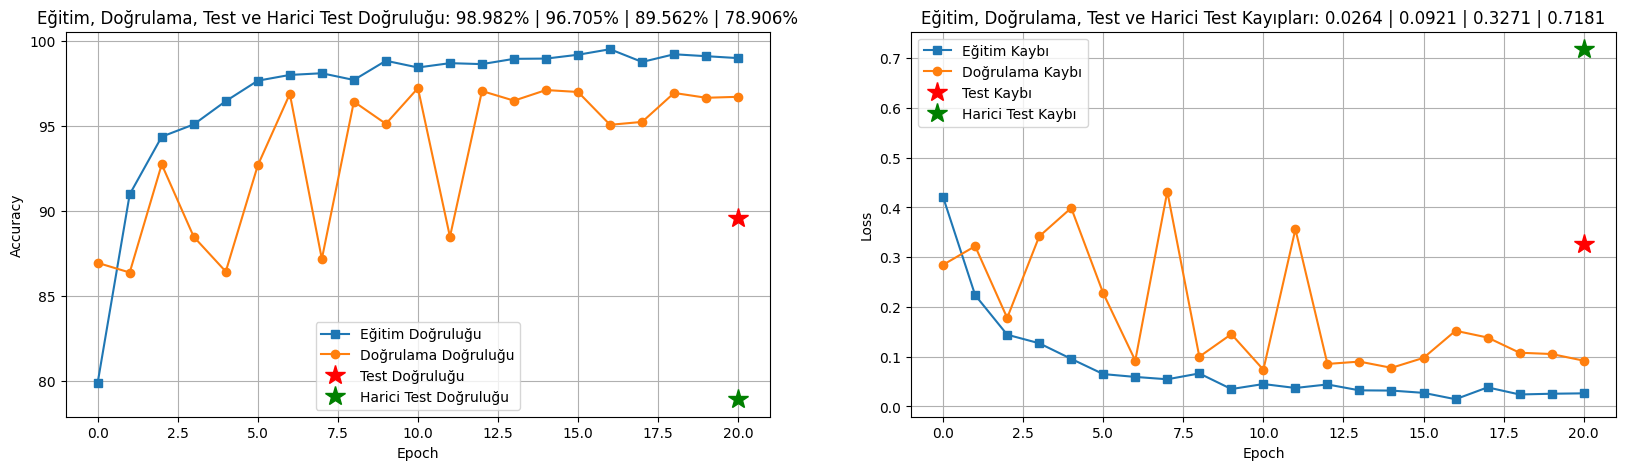

In [ ]:
# Plot the accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(trainAcc,"s-", label='Eğitim Doğruluğu')
ax[0].plot(devAcc,"o-", label='Doğrulama Doğruluğu')
ax[0].plot(trainAcc.shape[0]-1,testAcc,"r*",markersize=15, label='Test Doğruluğu')
ax[0].plot(trainAcc.shape[0]-1,externalAcc,"g*",markersize=15, label='Harici Test Doğruluğu')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Eğitim, Doğrulama, Test ve Harici Test Doğruluğu: {trainAcc[-1]:.3f}% | {devAcc[-1]:.3f}% | {testAcc:.3f}% | {externalAcc:.3f}%')
ax[0].grid()
ax[0].legend()

ax[1].plot(trainLoss,"s-", label='Eğitim Kaybı')
ax[1].plot(devLoss,"o-", label='Doğrulama Kaybı')
ax[1].plot(trainLoss.shape[0]-1,testLoss,"r*",markersize=15, label='Test Kaybı')
ax[1].plot(trainLoss.shape[0]-1,externalLoss,"g*",markersize=15, label='Harici Test Kaybı')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title(f'Eğitim, Doğrulama, Test ve Harici Test Kayıpları: {trainLoss[-1]:.4f} | {devLoss[-1]:.4f} | {testLoss:.4f} | {externalLoss:.4f}')
ax[1].grid()
ax[1].legend()

plt.show()

In [ ]:
# Predict the model

train_predictions = []
train_actual_labels = []

for X, y in train_loader:
    X = X.to(device)
    with torch.no_grad():
        yHat = net(X)
        train_predictions.append(yHat)
        train_actual_labels.append(y)

train_predictions = torch.cat(train_predictions).cpu()
train_actual_labels = torch.cat(train_actual_labels).cpu()

dev_predictions = []
dev_actual_labels = []

for X, y in dev_loader:
    X = X.to(device)
    with torch.no_grad():
        yHat = net(X)
        dev_predictions.append(yHat)
        dev_actual_labels.append(y)

dev_predictions = torch.cat(dev_predictions).cpu()
dev_actual_labels = torch.cat(dev_actual_labels).cpu()

test_predictions = []
test_actual_labels = []

for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        yHat = net(X)
        test_predictions.append(yHat)
        test_actual_labels.append(y)

test_predictions = torch.cat(test_predictions).cpu()
test_actual_labels = torch.cat(test_actual_labels).cpu()

external_predictions = []
external_actual_labels = []

for X, y in external_loader:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        yHat = net(X)
        external_predictions.append(yHat)
        external_actual_labels.append(y)

external_predictions = torch.cat(external_predictions).cpu()
external_actual_labels = torch.cat(external_actual_labels).cpu()

print(f"Train predictions shape: {train_predictions.shape}")
print(f"Train actual labels shape: {train_actual_labels.shape}")
print(f"Dev predictions shape: {dev_predictions.shape}")
print(f"Dev actual labels shape: {dev_actual_labels.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test actual labels shape: {test_actual_labels.shape}")
print(f"External predictions shape: {external_predictions.shape}")
print(f"External actual labels shape: {external_actual_labels.shape}")

Train predictions shape: torch.Size([7072, 1])
Train actual labels shape: torch.Size([7072, 1])
Dev predictions shape: torch.Size([1760, 1])
Dev actual labels shape: torch.Size([1760, 1])
Test predictions shape: torch.Size([297, 1])
Test actual labels shape: torch.Size([297, 1])
External predictions shape: torch.Size([384, 1])
External actual labels shape: torch.Size([384, 1])


In [ ]:

# Confusion matrices

trainConf = skm.confusion_matrix(train_actual_labels, train_predictions>0)
devConf = skm.confusion_matrix(dev_actual_labels, dev_predictions>0)
testConf = skm.confusion_matrix(test_actual_labels, test_predictions>0)
externalConf = skm.confusion_matrix(external_actual_labels, external_predictions>0)

print(f"Train confusion matrix: \n {trainConf}")
print(f"Dev confusion matrix: \n {devConf}")
print(f"Test confusion matrix: \n {testConf}")
print(f"External confusion matrix: \n {externalConf}")

Train confusion matrix: 
 [[3532   20]
 [   1 3519]]
Dev confusion matrix: 
 [[825  33]
 [ 17 885]]
Test confusion matrix: 
 [[120  10]
 [ 21 146]]
External confusion matrix: 
 [[167  25]
 [ 56 136]]


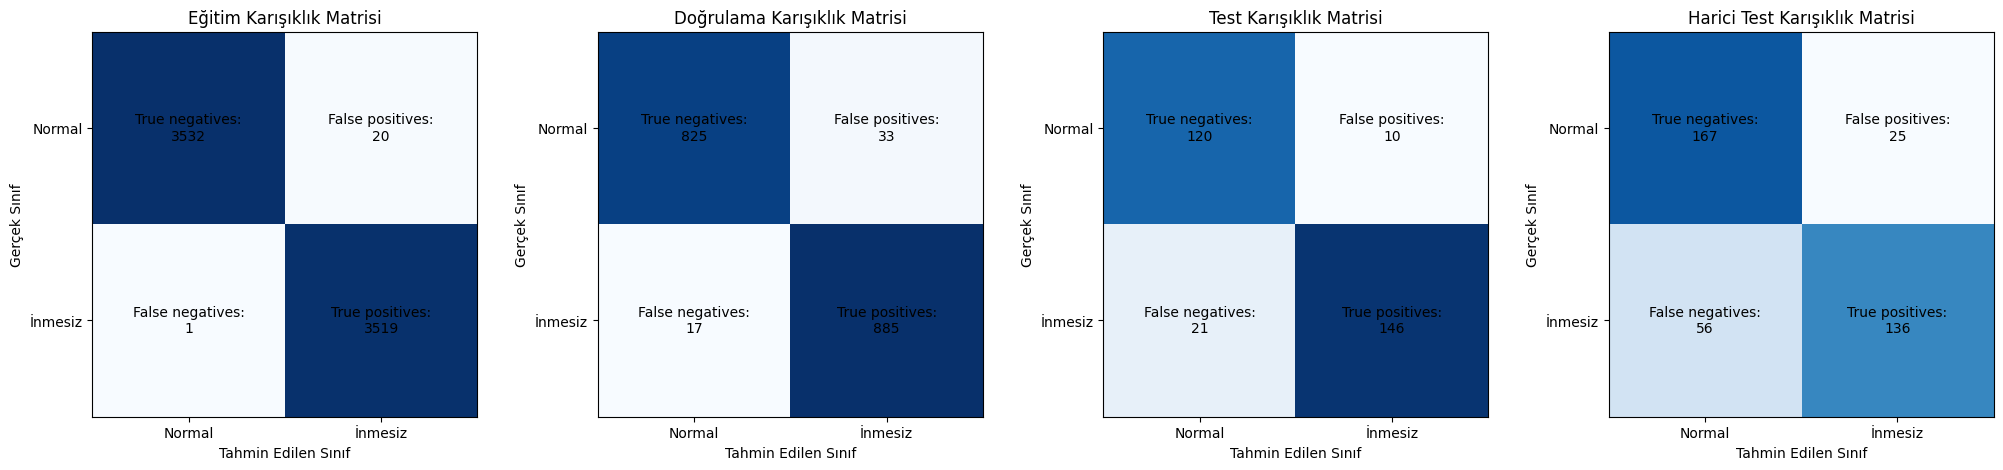

In [ ]:
# Confusion Matrices

fig,ax = plt.subplots(1,4,figsize=(25,5))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['Normal','İnmesiz'])
ax[0].set_yticklabels(['Normal','İnmesiz'])
ax[0].set_xlabel('Tahmin Edilen Sınıf')
ax[0].set_ylabel('Gerçek Sınıf')
ax[0].set_title('Eğitim Karışıklık Matrisi')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')

# confmat during DEV
ax[1].imshow(devConf,'Blues',vmax=len(dev_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['Normal','İnmesiz'])
ax[1].set_yticklabels(['Normal','İnmesiz'])
ax[1].set_xlabel('Tahmin Edilen Sınıf')
ax[1].set_ylabel('Gerçek Sınıf')
ax[1].set_title('Doğrulama Karışıklık Matrisi')

# add text labels
ax[1].text(0,0,f'True negatives:\n{devConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{devConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{devConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{devConf[0,1]}',ha='center',va='center')

# confmat during TEST
ax[2].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[2].set_xticks([0,1])
ax[2].set_yticks([0,1])
ax[2].set_xticklabels(['Normal','İnmesiz'])
ax[2].set_yticklabels(['Normal','İnmesiz'])
ax[2].set_xlabel('Tahmin Edilen Sınıf')
ax[2].set_ylabel('Gerçek Sınıf')
ax[2].set_title('Test Karışıklık Matrisi')

# add text labels
ax[2].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[2].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[2].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[2].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')

# confmat during EXTERNAL
ax[3].imshow(externalConf,'Blues',vmax=len(external_predictions)/2)
ax[3].set_xticks([0,1])
ax[3].set_yticks([0,1])
ax[3].set_xticklabels(['Normal','İnmesiz'])
ax[3].set_yticklabels(['Normal','İnmesiz'])
ax[3].set_xlabel('Tahmin Edilen Sınıf')
ax[3].set_ylabel('Gerçek Sınıf')
ax[3].set_title('Harici Test Karışıklık Matrisi')

# add text labels
ax[3].text(0,0,f'True negatives:\n{externalConf[0,0]}' ,ha='center',va='center')
ax[3].text(0,1,f'False negatives:\n{externalConf[1,0]}',ha='center',va='center')
ax[3].text(1,1,f'True positives:\n{externalConf[1,1]}' ,ha='center',va='center')
ax[3].text(1,0,f'False positives:\n{externalConf[0,1]}',ha='center',va='center')

plt.show()

In [ ]:

# Test & External Metrics

test_Acc = skm.accuracy_score(test_actual_labels, test_predictions>0)
test_Prec = skm.precision_score(test_actual_labels, test_predictions>0)
test_Rec = skm.recall_score(test_actual_labels, test_predictions>0)
test_F1 = skm.f1_score(test_actual_labels, test_predictions>0)

external_Acc = skm.accuracy_score(external_actual_labels, external_predictions>0)
external_Prec = skm.precision_score(external_actual_labels, external_predictions>0)
external_Rec = skm.recall_score(external_actual_labels, external_predictions>0)
external_F1 = skm.f1_score(external_actual_labels, external_predictions>0)

print("--------------- Test Metrics ---------------")
print(f"Test Accuracy: {test_Acc:.3f}")
print(f"Test Precision: {test_Prec:.3f}")
print(f"Test Recall: {test_Rec:.3f}")
print(f"Test F1 Score: {test_F1:.3f}")

print("--------------- External Metrics ---------------")
print(f"External Accuracy: {external_Acc:.3f}")
print(f"External Precision: {external_Prec:.3f}")
print(f"External Recall: {external_Rec:.3f}")
print(f"External F1 Score: {external_F1:.3f}")

--------------- Test Metrics ---------------
Test Accuracy: 0.896
Test Precision: 0.936
Test Recall: 0.874
Test F1 Score: 0.904
--------------- External Metrics ---------------
External Accuracy: 0.789
External Precision: 0.845
External Recall: 0.708
External F1 Score: 0.771


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns

class BinaryConfidenceAnalysis:
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def get_predictions(self):
        """Get predictions and probabilities from test data"""
        y_true = []
        y_pred = []
        y_probs = []  # Probability of positive class (class 1)

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                # Handle different model output formats
                if outputs.shape[1] == 1:  # Single output (sigmoid)
                    probs = torch.sigmoid(outputs).squeeze()
                    preds = (probs >= 0.5).long()
                else:  # Two outputs (softmax)
                    probs = torch.softmax(outputs, dim=1)[:, 1]
                    preds = (probs >= 0.5).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        return np.array(y_true), np.array(y_pred), np.array(y_probs)

    def bootstrap_metrics(self, n_iterations=1000, ci=95):
        """Calculate metrics with confidence intervals using bootstrap"""
        y_true, y_pred, _ = self.get_predictions()

        # Arrays to store bootstrap results
        precisions = np.zeros(n_iterations)
        recalls = np.zeros(n_iterations)
        f1_scores = np.zeros(n_iterations)

        n_samples = len(y_true)

        # Bootstrap loop
        for i in range(n_iterations):
            # Sample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)

            # Calculate metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true[indices], y_pred[indices],
                average='binary', zero_division=0
            )

            precisions[i] = precision
            recalls[i] = recall
            f1_scores[i] = f1

        # Calculate confidence intervals
        alpha = (100 - ci) / 100 / 2
        ci_lower = alpha
        ci_upper = 1 - alpha

        results = {
            'precision': {
                'mean': np.mean(precisions),
                'ci': np.quantile(precisions, [ci_lower, ci_upper])
            },
            'recall': {
                'mean': np.mean(recalls),
                'ci': np.quantile(recalls, [ci_lower, ci_upper])
            },
            'f1': {
                'mean': np.mean(f1_scores),
                'ci': np.quantile(f1_scores, [ci_lower, ci_upper])
            }
        }

        return results

    def plot_metrics_with_ci(self):
        """Plot metrics with confidence intervals"""
        results = self.bootstrap_metrics()

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Metrics to plot
        metrics = ['precision', 'recall', 'f1']
        x_pos = np.arange(len(metrics))

        # Extract values
        means = [results[m]['mean'] for m in metrics]
        errors = [
            [results[m]['mean'] - results[m]['ci'][0] for m in metrics],
            [results[m]['ci'][1] - results[m]['mean'] for m in metrics]
        ]

        # Create bar plot with error bars
        ax.bar(x_pos, means, yerr=errors, align='center', alpha=0.7, capsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1.1)
        ax.set_ylabel('Score')
        ax.set_title('Performance Metrics with 95% Confidence Intervals')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + 0.05, f'{v:.2f}', ha='center')

        return fig

    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        y_true, y_pred, _ = self.get_predictions()

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Normalize the confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')

        return plt.gcf()

    def plot_probability_distribution(self):
        """Plot probability distribution by class"""
        y_true, _, y_probs = self.get_predictions()

        # Ensure arrays are 1D
        y_true = np.array(y_true).flatten()
        y_probs = np.array(y_probs).flatten()

        # Debug information
        print(f"Shape of y_true: {y_true.shape}")
        print(f"Shape of y_probs: {y_probs.shape}")
        print(f"Unique values in y_true: {np.unique(y_true)}")

        plt.figure(figsize=(10, 6))

        # Create mask arrays for indexing
        mask_class0 = (y_true == 0)
        mask_class1 = (y_true == 1)

        # Make sure we have samples from both classes
        if np.any(mask_class0) and np.any(mask_class1):
            # Separate probabilities by true class
            class0_probs = y_probs[mask_class0]
            class1_probs = y_probs[mask_class1]

            # Plot distributions
            sns.histplot(class0_probs, color='blue', alpha=0.5,
                         bins=20, label='True Class 0')
            sns.histplot(class1_probs, color='red', alpha=0.5,
                         bins=20, label='True Class 1')

            # Add decision threshold line
            plt.axvline(x=0.5, color='black', linestyle='--')

            plt.xlabel('Predicted Probability of Class 1')
            plt.ylabel('Count')
            plt.title('Distribution of Predicted Probabilities by True Class')
            plt.legend()
        else:
            # Handle case where only one class is present
            present_class = 1 if np.any(mask_class1) else 0
            plt.text(0.5, 0.5, f"Only class {present_class} present in dataset",
                     ha='center', va='center', fontsize=14)
            plt.title("Unable to Plot Distribution - Single Class")

        return plt.gcf()

    def plot_calibration_curve(self):
        """Plot calibration curve with confidence interval"""
        y_true, _, y_probs = self.get_predictions()

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)

        # Calculate standard error for binomial proportion
        n_bins = len(prob_true)
        bin_total = np.bincount(np.digitize(y_probs, np.linspace(0, 1, n_bins + 1)) - 1,
                              minlength=n_bins)

        # For confidence interval
        std_err = np.sqrt(prob_true * (1 - prob_true) / np.maximum(bin_total, 1))
        ci = 1.96 * std_err  # 95% confidence interval

        # Plot
        plt.figure(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Plot with confidence intervals
        plt.errorbar(prob_pred, prob_true, yerr=ci,
                    marker='o', markersize=6, linewidth=2,
                    label='Model Calibration')

        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve with 95% Confidence Interval')
        plt.legend(loc='lower right')
        plt.grid(True)

        return plt.gcf()

Shape of y_true: (297,)
Shape of y_probs: (297,)
Unique values in y_true: [0. 1.]


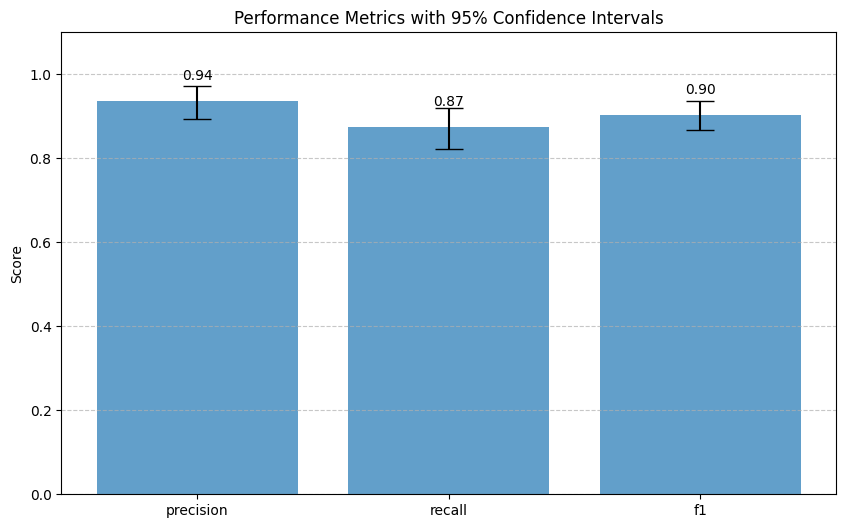

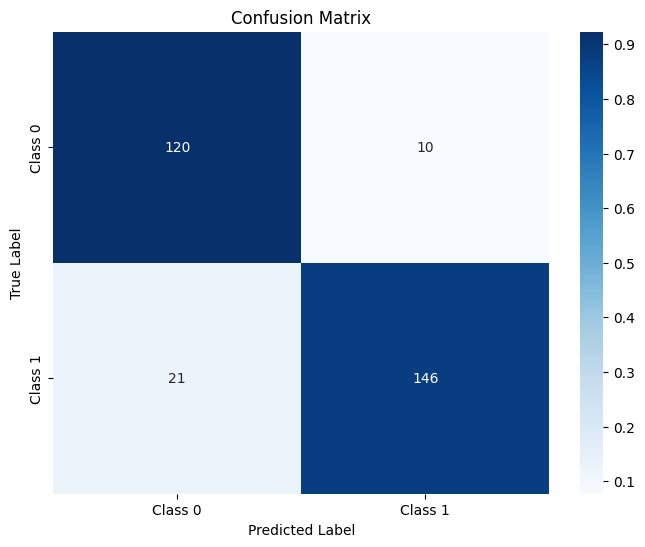

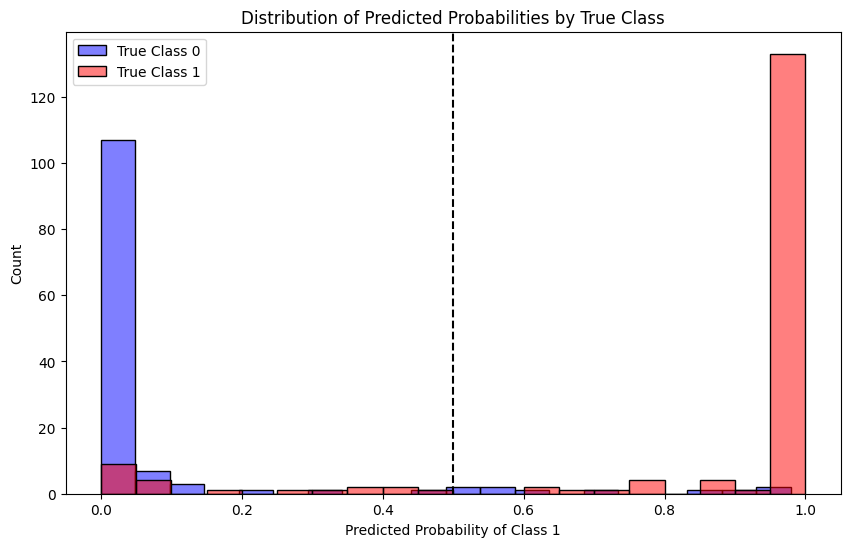

In [ ]:
analyzer = BinaryConfidenceAnalysis(net, test_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
# # Display all plots
plt.show()